In [3]:
!pip install --upgrade diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.2 MB/s eta 0:00:0000:0100:01


In [4]:
import torch
from torch import autocast
import numpy as np

from transformers import CLIPTextModel, CLIPTokenizer
from torchvision import transforms as tfms

from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, DDIMScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler

from tqdm import tqdm
from PIL import Image

from IPython.display import HTML
from base64 import b64encode

## Stable Diffusion Model

In [35]:
class StableDiffusionModel:

    def __init__(self, vae, tokenizer, text_encoder, unet, scheduler_LMS, scheduler_DDIM):
        self.vae = vae
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder
        self.unet = unet
        self.scheduler_LMS = scheduler_LMS
        self.scheduler_DDIM = scheduler_DDIM
        self.device = "cuda" if torch.cuda.is_available() else "cpu"


    def get_text_embeddings(self, text: list[str]) -> torch.Tensor:
        # tokenize the text
        tokenized_text = self.tokenizer(text,
                                        padding="max_length",
                                        max_length=self.tokenizer.model_max_length,
                                        truncation=True,
                                        return_tensors="pt")

        # embed the text
        with torch.no_grad():
            text_embeddings = self.text_encoder(tokenized_text.input_ids.to(self.device))[0]
        return text_embeddings

    def get_prompts_embeddings(self, prompts: list[str]) -> torch.Tensor:
        # we will use classifier-free guidance in our diffusion
        conditioned_prompt_embeddings = self.get_text_embeddings(prompts)
        unconditioned_prompt_embeddings = self.get_text_embeddings([''] * len(prompts))

        prompt_embeddings = torch.cat([unconditioned_prompt_embeddings, conditioned_prompt_embeddings])
        return prompt_embeddings


    def get_latents(self,
                    prompt_embeddings: torch.Tensor,
                    height: int = 512, width: int = 512,
                    num_inference_steps: int = 50,
                    guidance_scale: float = 7.5,
                    img_latents: torch.Tensor = None) -> torch.Tensor:
        # obtains the latents from the image

        # if no image latent is passed, start reverse diffusion with random noise
        if img_latents is None:
            # we want to include both conditional and unconditional embeddings from the prompt
            # we will also work with a smaller size of images
            img_latents = torch.randn(
                (len(prompt_embeddings) // 2, self.unet.in_channels, height // 8, width // 8),
                device=self.device
            )

        # set the number of inference steps for the scheduler
        self.scheduler_LMS.set_timesteps(num_inference_steps)

        # scale the latent embeddings
        img_latents = img_latents * self.scheduler_LMS.sigmas[0]

        # use autocast for AMP, speeding up the process
        with autocast('cuda'):
            for i, t in tqdm(enumerate(self.scheduler_LMS.timesteps)):
                # do a single forward pass for both the conditional and unconditional latents

                # double the tensor for both types
                latent_model_input = torch.cat([img_latents] * 2)
                sigma = self.scheduler_LMS.sigmas[i]
                # normalization of the data
                latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

                # predict noise residuals
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeddings)['sample']

                # separate the predictions for the unconditional and conditional chunks
                noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)

                # perform the guidance
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

                # remove the noise from the current sample
                # i.e. go from x_t to x_{t-1}
                img_latents = self.scheduler_LMS.step(noise_pred, t, img_latents)['prev_sample']

        return img_latents

    def decode_latents(self, img_latents: torch.Tensor) -> torch.Tensor:
        img_latents = img_latents / 0.18215

        with torch.no_grad():
            images = self.vae.decode(img_latents)['sample']

        images = images.detach().cpu()
        return images

    def transform_images(self, images: torch.Tensor) -> list[Image.Image]:
        # transform images from [-1, 1] to [0, 1]
        images = (images / 2 + 0.5).clamp(0, 1)
        # permute the channels
        images = images.permute(0, 2, 3, 1).numpy()
        # scale the images to [0, 255]
        images = (images * 255).round().astype("uint8")
        # convert to PIL images
        images = [Image.fromarray(image) for image in images]
        return images


    def text_to_image(self,
                      prompts: list[str],
                      height: int = 512, width: int = 512,
                      num_inference_steps: int = 50,
                      guidance_scale: float = 7.5,
                      img_latents: torch.Tensor = None) -> list[Image.Image]:
        # get prompt embeddings
        prompt_embeddings = self.get_prompts_embeddings(prompts)

        # get image latents
        img_latents = self.get_latents(prompt_embeddings, height, width, num_inference_steps, guidance_scale, img_latents)

        # decode the image latents
        images = self.decode_latents(img_latents)

        # transform the images in PIL images
        images = self.transform_images(images)

        return images



    def encode_latents(self, images: list[Image.Image]) -> torch.Tensor:
        images = np.stack([np.array(image) for image in images], axis=0)
        
        # operations reflected in transform_images as inverses
        # scale images to [-1, 1]
        images = 2 * ((images / 255) - 0.5)
        # permute the channels
        images = torch.from_numpy(images).float().permute(0, 3, 1, 2)

        # encode the images
        img_latents_distribution = self.vae.encode(images.to(self.device))
        img_latents = img_latents_distribution['latent_dist'].mean.clone()
        img_latents *= 0.18215

        return img_latents

    def get_latents_from_images(self, 
                                img_latents: torch.Tensor, 
                                prompt_embeddings: torch.Tensor, 
                                height: int = 512, width: int = 512, 
                                num_inference_steps: int = 50, 
                                guidance_scale: float = 7.5, 
                                start_step: int = 10) -> torch.Tensor:
        # set the number of inference steps for the scheduler
        self.scheduler_DDIM.set_timesteps(num_inference_steps)

        if start_step > 0:
            start_timestep = self.scheduler_DDIM.timesteps[start_step]
            start_timesteps = start_timestep.repeat(img_latents.shape[0]).long()

            noise = torch.randn_like(img_latents)
            img_latents = self.scheduler_DDIM.add_noise(img_latents, noise, start_timesteps)

        # this section is similar to the previous one in get_latents
        with autocast('cuda'):
            for i, t in tqdm(enumerate(self.scheduler_DDIM.timesteps[start_step:])):
                latent_model_input = torch.cat([img_latents] * 2)
                
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=prompt_embeddings)['sample']

                noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

                img_latents = self.scheduler_DDIM.step(noise_pred, t, img_latents)['prev_sample']

        return img_latents

    
    def image_to_image(self, image: Image.Image, prompts: list[str],
                       height: int = 512, width: int = 512, num_inference_steps: int = 50,
                       guidance_scale: float = 7.5, start_step: int = 10) -> list[Image.Image]:
        # get prompt embeddings
        prompt_embeddings = self.get_prompts_embeddings(prompts)

        # encode the images
        img_latents = self.encode_latents([image])

        # get image latents
        img_latents = self.get_latents_from_images(img_latents, prompt_embeddings, height, width, num_inference_steps, guidance_scale, start_step)

        # decode the image latents
        images = self.decode_latents(img_latents)

        # transform the images in PIL images
        images = self.transform_images(images)

        # clear cuda cache
        torch.cuda.empty_cache()

        return images


# Model Initialization

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name = 'CompVis/stable-diffusion-v1-4'

vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(device)

tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")

text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(device)

unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(device)

scheduler_LMS = LMSDiscreteScheduler.from_pretrained(model_name, subfolder="scheduler")
# scheduler_LMS = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear', num_train_timesteps=1000)

scheduler_DDIM = DDIMScheduler.from_pretrained(model_name, subfolder="scheduler")
# scheduler_DDIM = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear', num_train_timesteps=1000)

# Testing

In [42]:
model = StableDiffusionModel(vae, tokenizer, text_encoder, unet, scheduler_LMS, scheduler_DDIM)

prompts = ["A red car on a highway", "A green, scary aesthetic dragon breathing fire near a group of heroic firefighters"]

images_prompt1 = model.text_to_image(prompts)

/tmp/ipykernel_31/1125296800.py:48: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (len(prompt_embeddings) // 2, self.unet.in_channels, height // 8, width // 8),
50it [00:16,  3.11it/s]


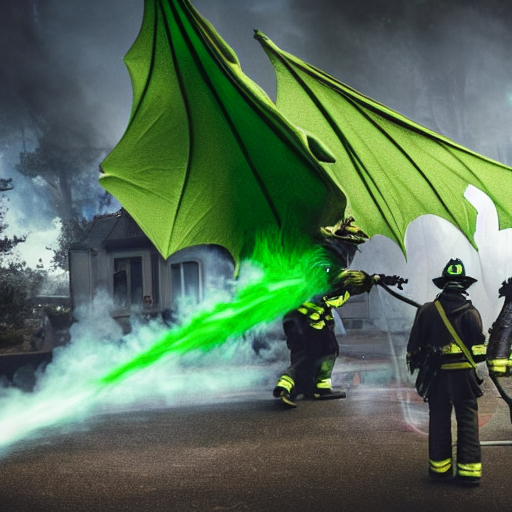

In [43]:
images_prompt1[1]

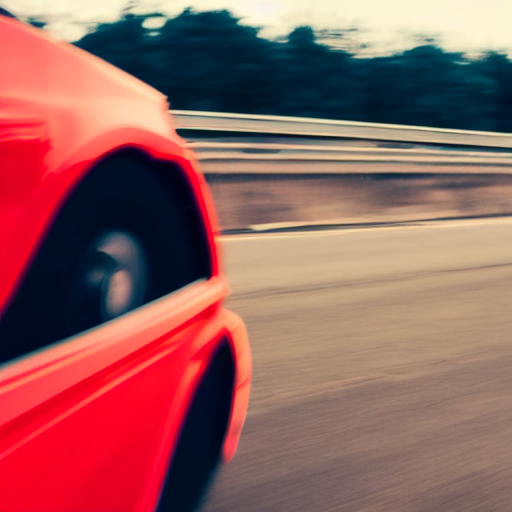

In [44]:
images_prompt1[0]

In [12]:
prompt = ["Aesthetic star wars spaceship with an aethethic background, Ultra HD, futuristic, sharp, octane render, neon"]

images_prompt2 = model.text_to_image(prompt)

/tmp/ipykernel_31/451994181.py:48: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (len(prompt_embeddings) // 2, self.unet.in_channels, height // 8, width // 8),
50it [00:08,  6.18it/s]


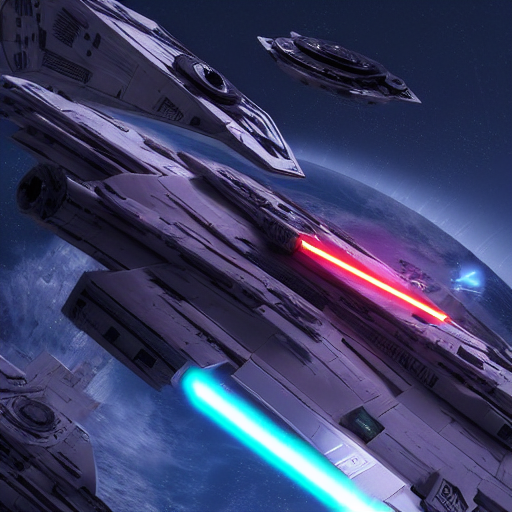

In [13]:
images_prompt2[0]

In [14]:
images_prompt2[0].save("spaceship_text_to_image.png")

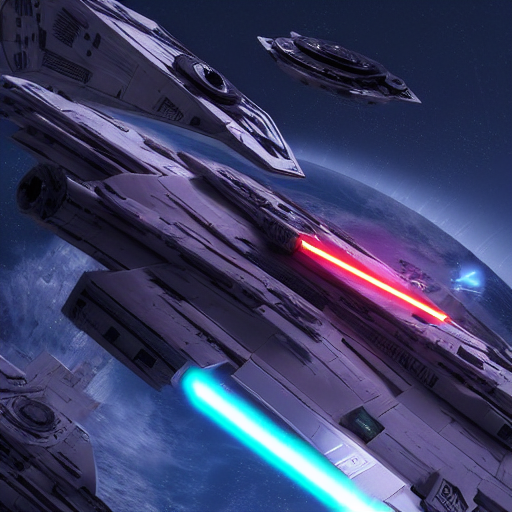

In [15]:
original_spaceship_image = Image.open("generated_images/spaceship_text_to_image.png")
original_spaceship_image

In [52]:
import torch
import gc

### If you get OOM errors, execute this cell
# del model
# Clear the CUDA cache
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [53]:
!nvidia-smi

Mon Nov  4 14:35:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             38W /   70W |    8425MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [48]:
model = StableDiffusionModel(vae, tokenizer, text_encoder, unet, scheduler_LMS, scheduler_DDIM)

prompt = ["Aesthetic star wars spaceship with an aethethic background, Ultra HD, futuristic, sharp, octane render, neon"]

similar_images_prompt1 = model.image_to_image(original_spaceship_image, prompt)
#similar_images_prompt1 = model.image_to_image(images_prompt2[0], prompt)

40it [00:06,  5.96it/s]


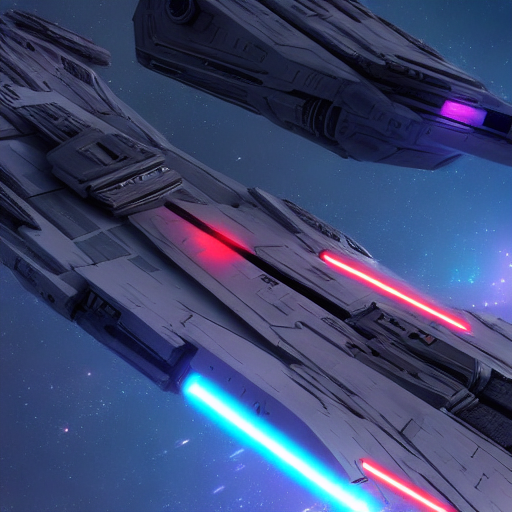

In [49]:
similar_images_prompt1[0]

In [54]:
prompt = ["Aesthetic dark star wars spaceship, Ultra HD, futuristic, sharp, octane render, neon"]

similar_images_prompt2 = model.image_to_image(original_spaceship_image, prompt,
                          num_inference_steps=50,
                          start_step=40)

10it [00:01,  6.20it/s]


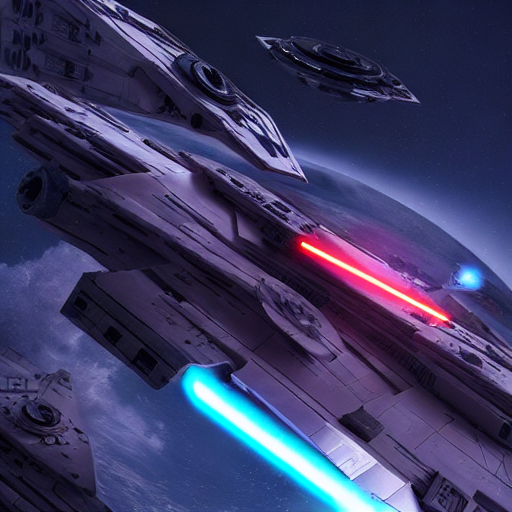

In [55]:
similar_images_prompt2[0]